# Care restoration (prediction)

In this notebook we use the trained CARE network to restore an image

In [1]:
from skimage.io import imread, imsave
from tnia.plotting.projections import show_xyz_slice, show_xyz_max
from csbdeep.models import Config, CARE
from skimage.transform import resize
import sys
sys.path.append('../')
import decon_helper as dh
import os

tnia available
stackview available


# Load an input image

In this cell we load an input image.  Note that the image is bigger than the patch size we trained on.  The CSBDeep framework will take care of applying the network in chunks. 

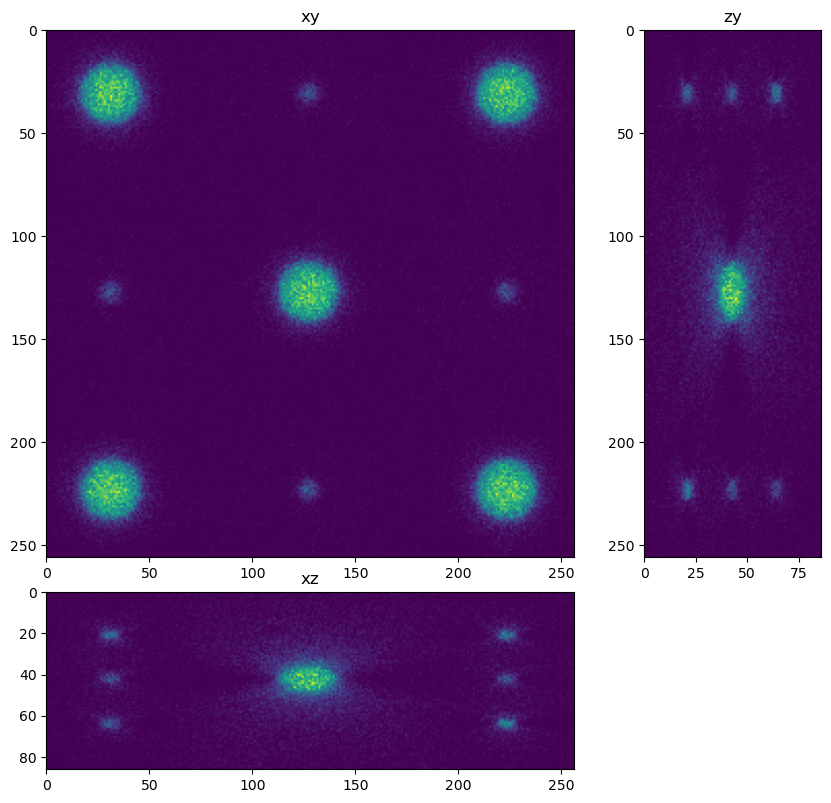

In [37]:

#input = imread('../../data/deconvolution/nuclei4_out_c90_dr10_image.tif')
input = imread('../../data/deconvolution/simulation/im_no_aberration_3.tif')
dh.show_xyz_slice(input, 'tnia')

In [38]:
nmin=input.min()
nmax=input.max()
normalized = (input.astype('float32')-nmin) / (nmax - nmin)

# Load the model

Load the model that we trained in the previous notebook

In [39]:
# load the model using the name of the model and the path to the model
model = CARE(None, 'big_small_noisy_notnoisy_model_2', basedir='../../models')

Loading network weights from 'weights_best.h5'.


# Apply the model

In [40]:
restored = model.predict(normalized, axes='ZYX', n_tiles=(1, 2, 2), normalizer=None)

1/1 [==============================] - 0s 417ms/step


 25%|██▌       | 1/4 [00:00<?, ?it/s]

1/1 [==============================] - 0s 100ms/step


 50%|█████     | 2/4 [00:05<00:05,  2.83s/it]

1/1 [==============================] - 0s 88ms/step


 75%|███████▌  | 3/4 [00:11<00:04,  4.15s/it]

1/1 [==============================] - 0s 89ms/step


100%|██████████| 4/4 [00:19<00:00,  4.75s/it]


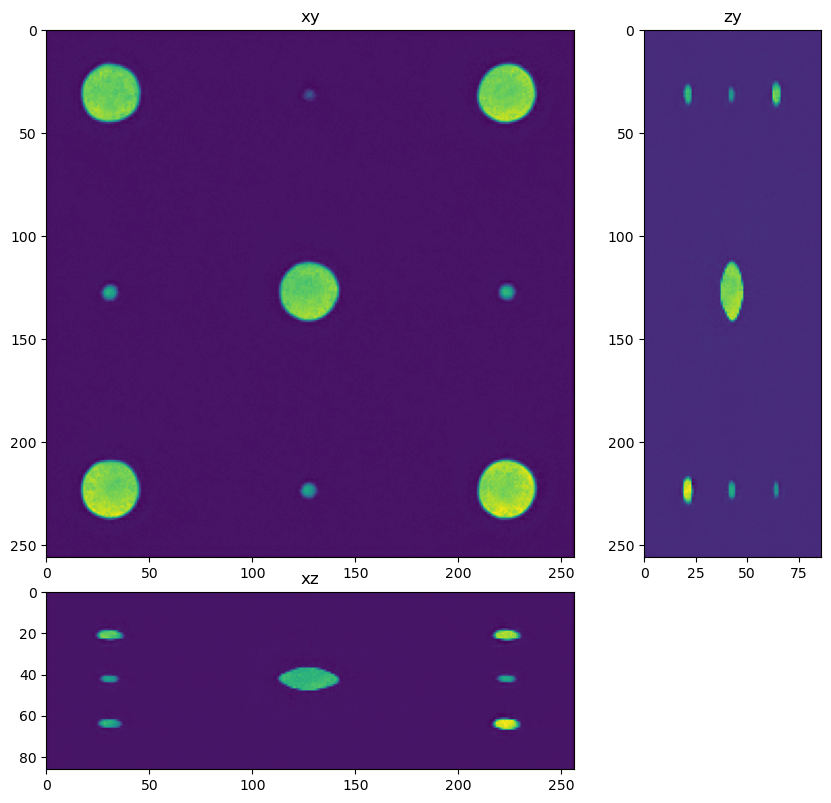

In [41]:
dh.show_xyz_slice(restored, 'tnia')

In [29]:
import napari
viewer = napari.Viewer()
viewer.add_image(input, name='input')
viewer.add_image(restored, name='restored')

<Image layer 'restored' at 0x1ca0b0466a0>